In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics       import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error,r2_score
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from statsmodels.tsa.seasonal import seasonal_decompose

In [31]:
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

In [32]:
df = pd.read_html('http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view', skiprows=1, thousands='.', decimal=',')[0]


In [33]:
df = df.rename(columns={0:'Date',1:'Price'})
df.isnull().sum()

Date     0
Price    0
dtype: int64

In [34]:
df['Date'] = df['Date'].str.replace('/', '-')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [35]:
date_min = df['Date'].min()
date_max = df['Date'].max()

In [36]:
df.to_excel('data.xlsx',index=False)

In [37]:
# Definindo a coluna 'A' como o índice
df = df.set_index('Date')

In [38]:
df.head()

,Price
Date,
2024-05-13,83.18
2024-05-10,83.39
2024-05-09,83.27
2024-05-08,82.44
2024-05-07,82.69


<AxesSubplot:xlabel='Date'>

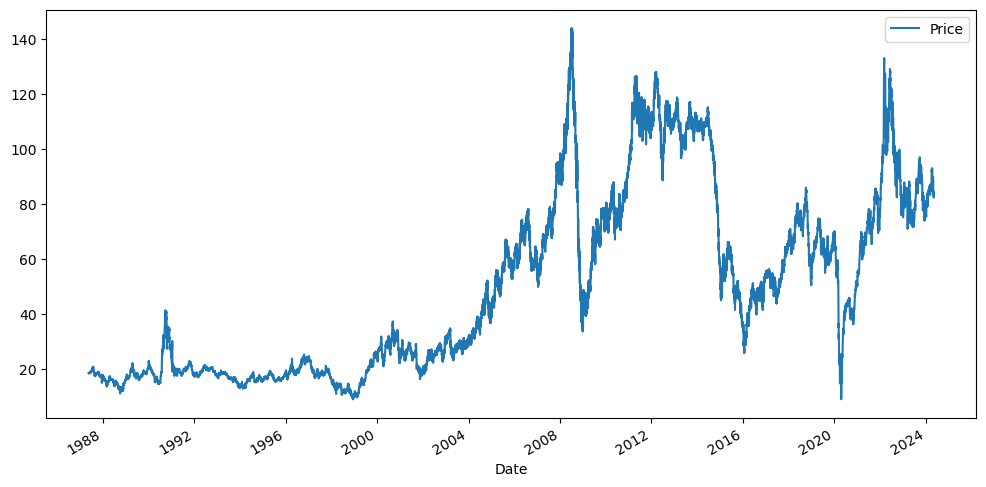

In [39]:
df.plot(figsize=(12,6))

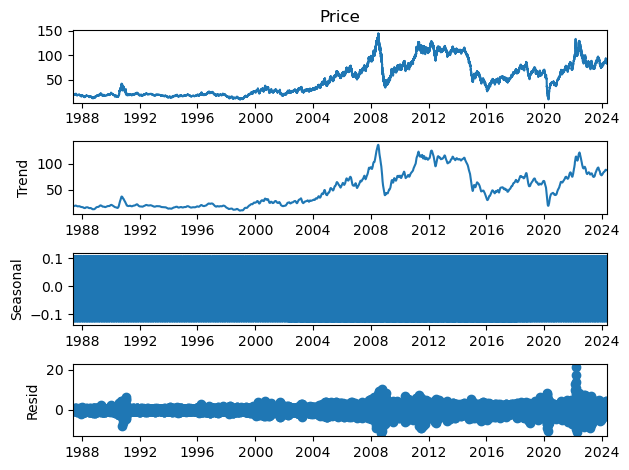

In [43]:
# Ordenando o índice de data em ordem crescente
df = df.sort_index()

results = seasonal_decompose(df['Price'],period=30)
results.plot();

In [44]:
# Filtrar o DataFrame para datas a partir de 01/01/2014
df = df.loc['2020-01-01':]

In [45]:
# Create additional features using the datetime index
#df['Day_of_week'] = df.index.dayofweek
#df['Month'] = df.index.month
#df['Year'] = df.index.year

df.head()

,Price
Date,
2020-01-02,67.05
2020-01-03,69.08
2020-01-06,70.25
2020-01-07,68.74
2020-01-08,67.31


In [46]:
len(df)

1110

In [47]:
train = df.iloc[:1091]
test = df.iloc[1091:]

In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [49]:
df.head(),df.tail()

(            Price
 Date             
 2020-01-02  67.05
 2020-01-03  69.08
 2020-01-06  70.25
 2020-01-07  68.74
 2020-01-08  67.31,
             Price
 Date             
 2024-05-07  82.69
 2024-05-08  82.44
 2024-05-09  83.27
 2024-05-10  83.39
 2024-05-13  83.18)

In [50]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaler.fit(test)
scaled_test = scaler.transform(test)

In [51]:
scaled_train[:10]

array([[0.46695148],
       [0.48331453],
       [0.49274545],
       [0.48057392],
       [0.46904724],
       [0.46316299],
       [0.4646945 ],
       [0.44349508],
       [0.44599387],
       [0.43664356]])

In [52]:
# define generator
n_input = 5
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [53]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.46695148 0.48331453 0.49274545 0.48057392 0.46904724]
Predict this y: 
 [[0.46316299]]


In [54]:
X.shape

(1, 5, 1)

In [55]:
# We do the same thing, but now instead for 12 months
n_input = 5
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [56]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [57]:
# Crie o modelo
#model = Sequential()
#model.add(LSTM(90, activation='sigmoid', input_shape=(n_input, n_features)))
#model.add(Dense(1))  # Mantenha a camada de saída
#model.compile(optimizer='adam', loss='mse')

In [58]:
# define model
model = Sequential()
model.add(LSTM(80, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80)                26240     
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 26,321
Trainable params: 26,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
1086/1086 [==============================] - 44s 28ms/step - loss: 0.0065
Epoch 2/50
1086/1086 [==============================] - 9s 8ms/step - loss: 9.9358e-04
Epoch 3/50
1086/1086 [==============================] - 9s 8ms/step - loss: 8.7510e-04
Epoch 4/50
1086/1086 [==============================] - 8s 8ms/step - loss: 7.7579e-04
Epoch 5/50
1086/1086 [==============================] - 9s 8ms/step - loss: 7.4033e-04
Epoch 6/50
1086/1086 [==============================] - 9s 9ms/step - loss: 6.2134e-04
Epoch 7/50
1086/1086 [==============================] - 10s 9ms/step - loss: 5.8216e-04
Epoch 8/50
1086/1086 [==============================] - 8s 7ms/step - loss: 5.5496e-04
Epoch 9/50
1086/1086 [==============================] - 9s 8ms/step - loss: 5.0745e-04
Epoch 10/50
1086/1086 [==============================] - 8s 7ms/step - loss: 4.8356e-04
Epoch 11/50
1086/1086 [==============================] - 9s 8ms/step - loss: 4.6110e-04
Epoch 12/50
1086/1086 [===================

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
last_train_batch = scaled_train[-n_input:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(last_train_batch)

In [ ]:
scaled_test[0]

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
test_predictions

In [ ]:
test.head(14)

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions

In [ ]:
test.plot(figsize=(14,5))

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Price'],test['Predictions']))
print(rmse)

In [ ]:
test.head()

In [ ]:
# performance com 90 dias a partir de 2022> mae 3,27 mape 0,03 rmse 3,67
# performance com 10 dias a partir de 2020> mae 1,47 mape 0,017 rmse 1,90
# performance com 5 dias a partir de 2020> mae 2,19 mape 0,025 rmse 3,03
# parametros 
#model = Sequential()
#model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
#model.add(Dense(1))
#model.compile(optimizer='adam', loss='mse')

In [ ]:

lstm_performance = ml_error( "LSTM PERFORMANCE", test['Price'],test['Predictions'] )
lstm_performance